--- Full Ansatz Evaluation (N=4, L=20) ---
Total Parameters: 260
Sampling 500 states...


100%|██████████| 500/500 [00:20<00:00, 23.91it/s]


Calculating Metrics...

[Results]
Expressibility (KL Div): 0.0017 (Lower is better)
Entangling Capability (MW): 0.8228 (Max: 1.0)


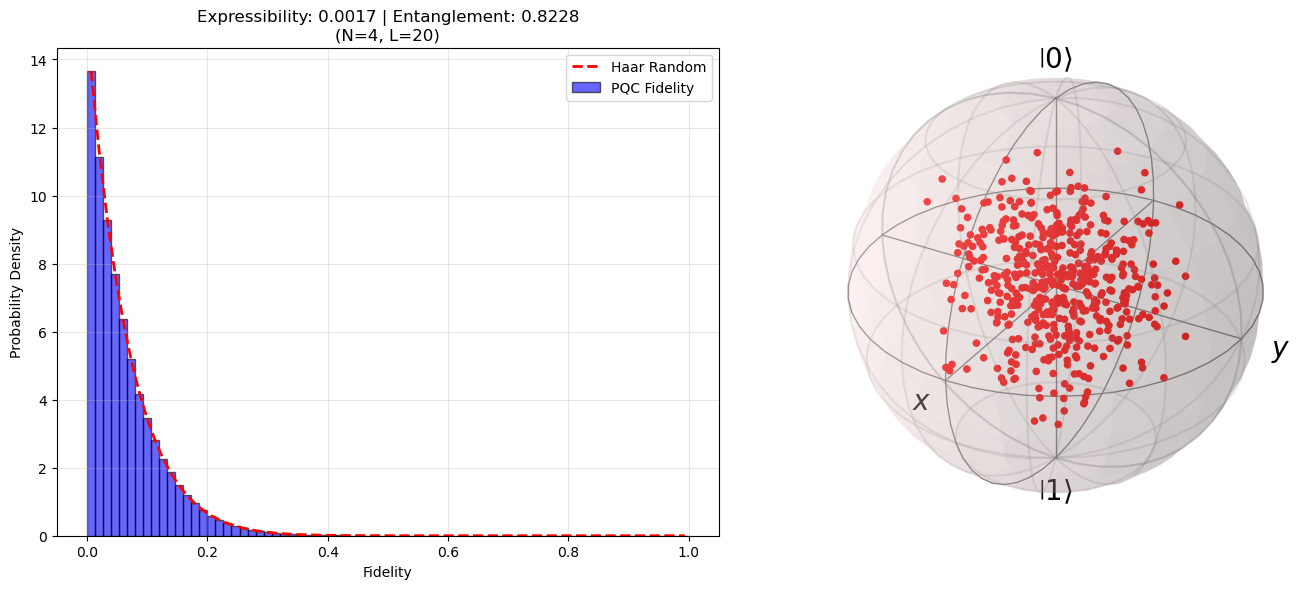

In [50]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import qutip
import itertools
from tqdm import tqdm

# ==========================================
# 1. Ansatz & Circuit Definitions
# ==========================================

def ConvUnit(params, wires):
    """Vatan-Williams Optimal Decomposition (Fig 6.)"""
    qml.RZ(-np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(np.pi/2 - 2*params[0], wires=wires[0])
    qml.RY(2*params[1] - np.pi/2, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(np.pi/2 - 2*params[2], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(np.pi/2, wires=wires[0])

def ConvLayer(params, wires, layers):
    # Conv Layer
    n = len(wires)
    param_idx = 0
    for rep in range(layers):
        for i in range(0, n-1, 2):
            conv_params = params[param_idx : param_idx + 3]
            param_idx += 3
            ConvUnit(conv_params, wires=[wires[i], wires[i+1]])
        for i in range(1, n-1, 2):
            conv_params = params[param_idx : param_idx + 3]
            param_idx += 3
            ConvUnit(conv_params, wires=[wires[i], wires[i+1]])
    return param_idx
    

def PhaseMixing(params, wires):
    """Star-Topology Entanglement + QFT"""
    n = len(wires)
    for i in range(n):
        qml.Hadamard(wires[i])
    for i in range(0, n-1, 1):
        qml.CZ(wires=[wires[i], wires[i+1]])
    for i in range(n):
        qml.RX(params[i], wires=wires[i])

def CustomAnsatz(params, wires, layers=1):
    n_qubits = len(wires)
    for i in wires:
        qml.RY(np.pi/4, wires=i) # Initial state
        
    param_idx = 0
    param_idx += ConvLayer(params, wires, layers)
    PhaseMixing(params[param_idx:], wires=wires)

# ==========================================
# 2. Metric Helper Functions
# ==========================================

def calculate_fidelity_distribution(samples):
    fidelities = []
    num_samples = len(samples)
    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            overlap = np.vdot(samples[i], samples[j])
            fid = np.abs(overlap) ** 2
            fidelities.append(fid)
    return np.array(fidelities)

def haar_probability(F, n_qubits):
    N = 2**n_qubits
    return (N - 1) * (1 - F) ** (N - 2)

def compute_expressibility(fidelities, n_qubits, n_bins=75):
    hist, bin_edges = np.histogram(fidelities, bins=n_bins, range=(0, 1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    haar_vals = haar_probability(bin_centers, n_qubits)
    
    epsilon = 1e-10
    hist = np.where(hist == 0, epsilon, hist)
    haar_vals = np.where(haar_vals == 0, epsilon, haar_vals)
    
    dx = 1.0 / n_bins
    kl_div = np.sum(hist * np.log(hist / haar_vals)) * dx
    return kl_div, hist, haar_vals, bin_centers

def compute_meyer_wallach(state_vector, n_qubits):
    psi = qutip.Qobj(state_vector, dims=[[2]*n_qubits, [1]*n_qubits])
    entanglement_sum = 0
    for k in range(n_qubits):
        rho_k = psi.ptrace(k)
        purity = (rho_k * rho_k).tr()
        entanglement_sum += 0.5 * (1 - purity)
    Q = (4 / n_qubits) * entanglement_sum
    return Q.real

# ==========================================
# 3. Visualization Helper (Bloch Sphere)
# ==========================================

def plot_bloch_sphere_distribution(states, title="State Distribution", ax=None):
    b = qutip.Bloch(fig=plt.gcf(), axes=ax)
    b.point_color = ['r']
    b.point_marker = ['o']
    b.point_size = [20]
    
    x_points, y_points, z_points = [], [], []
    
    for state in states:
        n_dim = state.shape[0]
        n_qubits = int(np.log2(n_dim))
        psi = qutip.Qobj(state, dims=[[2]*n_qubits, [1]*n_qubits])
        
        # Reduced density matrix for qubit 0
        if n_qubits > 1:
            rho = psi.ptrace(0)
        else:
            rho = psi * psi.dag()
            
        x_points.append((rho * qutip.sigmax()).tr().real)
        y_points.append((rho * qutip.sigmay()).tr().real)
        z_points.append((rho * qutip.sigmaz()).tr().real)
        
    b.add_points([x_points, y_points, z_points])
    b.title = title
    b.render()

# ==========================================
# 4. Combined Main Execution Function
# ==========================================

def evaluate_and_visualize_ansatz(n_qubits=4, n_layers=2, n_samples=1000):
    print(f"--- Full Ansatz Evaluation (N={n_qubits}, L={n_layers}) ---")
    
    # 1. Setup Circuit
    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev)
    def circuit_node(params):
        CustomAnsatz(params, wires=range(n_qubits), layers=n_layers)
        return qml.state()
    
    # 2. Count Params
    params_per_layer = 3 * (n_qubits - 1) + (n_qubits)
    total_params = params_per_layer * n_layers
    print(f"Total Parameters: {total_params}")
    
    # 3. Sample States (Run Once)
    states = []
    mw_measures = []
    
    print(f"Sampling {n_samples} states...")
    for _ in tqdm(range(n_samples)):
        params = np.random.uniform(0, 2*np.pi, total_params)
        state = circuit_node(params)
        states.append(state)
        mw_measures.append(compute_meyer_wallach(state, n_qubits))
        
    # 4. Compute Metrics
    print("Calculating Metrics...")
    fidelities = calculate_fidelity_distribution(states)
    expr_value, hist, haar, bins = compute_expressibility(fidelities, n_qubits)
    avg_entanglement = np.mean(mw_measures)
    
    print(f"\n[Results]")
    print(f"Expressibility (KL Div): {expr_value:.4f} (Lower is better)")
    print(f"Entangling Capability (MW): {avg_entanglement:.4f} (Max: 1.0)")
    
    # 5. Generate Plots (Combined Figure)
    # Create a figure with 2 subplots: Left (Histogram), Right (Bloch Sphere)
    fig = plt.figure(figsize=(14, 6))
    
    # --- Plot 1: Expressibility Histogram (Left) ---
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.bar(bins, hist, width=1.0/len(bins), alpha=0.6, label='PQC Fidelity', color='blue', edgecolor='black')
    ax1.plot(bins, haar, label='Haar Random', color='red', linestyle='--', linewidth=2)
    #ax1.set_title(f"Expressibility (KL={expr_value:.4f})")
    ax1.set_title(f"Expressibility: {expr_value:.4f} | Entanglement: {avg_entanglement:.4f}\n(N={n_qubits}, L={n_layers})")
    ax1.set_xlabel("Fidelity")
    ax1.set_ylabel("Probability Density")
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # --- Plot 2: Bloch Sphere (Right) ---
    # QuTiP's Bloch class requires an axes object to render into
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    plot_bloch_sphere_distribution(states, title=f"Bloch Sphere (MW={avg_entanglement:.4f})", ax=ax2)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example Run
    # Warning: n_samples determines plotting density and calculation time.
    evaluate_and_visualize_ansatz(n_qubits=4, n_layers=20, n_samples=500)

--- Comparing Measurement Capabilities (N=4) ---
Ansatz Params: 13, ANO Params (per measurement): 256
Sampling 500 configurations...


100%|██████████| 500/500 [00:04<00:00, 108.70it/s]


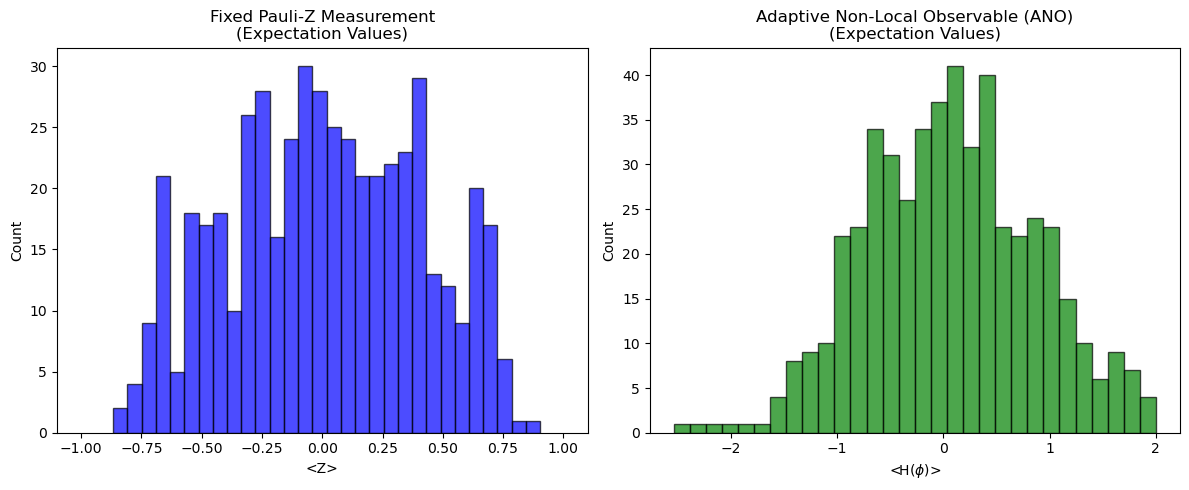

In [55]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# 1. ANO (Adaptive Non-Local Observable) Implementation
# ==========================================

def build_ano_observable(params, n_qubits):
    """
    Constructs a parametrized Hermitian matrix for ANO measurement based on Eq. (5)
    in 'Quantum Super-Resolution by Adaptive Non-Local Observables'.
    
    Args:
        params: Flat list/array of parameters.
        n_qubits: Number of qubits (k-local). Matrix size will be 2^k x 2^k.
    Returns:
        Hermitian Matrix (numpy array)
    """
    dim = 2 ** n_qubits
    matrix = np.zeros((dim, dim), dtype=np.complex128)
    
    # Param Index Tracker
    idx = 0
    
    # 1. Fill Diagonal Elements (Real)
    # params[0] to params[dim-1]
    for i in range(dim):
        matrix[i, i] = params[idx]
        idx += 1
        
    # 2. Fill Off-Diagonal Elements (Complex) and Symmetrize
    # We need to fill upper triangle, then copy conjugate to lower.
    for i in range(dim):
        for j in range(i + 1, dim):
            # Real part
            r_val = params[idx]
            idx += 1
            # Imaginary part
            i_val = params[idx]
            idx += 1
            
            val = r_val + 1j * i_val
            matrix[i, j] = val          # Upper triangle
            matrix[j, i] = np.conj(val) # Lower triangle (Hermitian property)
            
    return matrix

def count_ano_params(n_qubits):
    """Returns the number of parameters needed for a general Hermitian matrix of size 2^n."""
    dim = 2 ** n_qubits
    # Diagonal (dim) + Upper Triangle Real (dim*(dim-1)/2) + Upper Triangle Imag (dim*(dim-1)/2)
    # = dim + dim^2 - dim = dim^2
    return dim * dim


# ==========================================
# 3. Comparison Experiment
# ==========================================

def compare_ano_vs_pauli(n_qubits=2, n_layers=1, n_samples=300):
    """
    Compares the distribution of expectation values from fixed Pauli-Z vs. Adaptive ANO.
    Note: For ANO, we simulate 'Adaptivity' by sampling random Hermitian matrices,
    showing the potential range of learnable measurements.
    """
    print(f"--- Comparing Measurement Capabilities (N={n_qubits}) ---")
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    # Calculate Ansatz Params
    ansatz_params_per_layer = 3 * (n_qubits - 1) + (n_qubits)
    total_ansatz_params = ansatz_params_per_layer * n_layers
    
    # Calculate ANO Params
    total_ano_params = count_ano_params(n_qubits)
    print(f"Ansatz Params: {total_ansatz_params}, ANO Params (per measurement): {total_ano_params}")

    # --- QNodes ---
    
    # 1. Fixed Pauli Measurement
    @qml.qnode(dev)
    def circuit_pauli(ansatz_params):
        CustomAnsatz(ansatz_params, wires=range(n_qubits), layers=n_layers)
        # Measure Z on the first qubit (Standard approach)
        return qml.expval(qml.PauliZ(0)) 

    # 2. ANO Measurement
    @qml.qnode(dev)
    def circuit_ano(ansatz_params, ano_params):
        CustomAnsatz(ansatz_params, wires=range(n_qubits), layers=n_layers)
        # Construct Matrix H
        H = build_ano_observable(ano_params, n_qubits)
        # Measure Expectation of H
        return qml.expval(qml.Hermitian(H, wires=range(n_qubits)))

    # --- Sampling ---
    pauli_vals = []
    ano_vals = []
    
    print(f"Sampling {n_samples} configurations...")
    for _ in tqdm(range(n_samples)):
        # Generate a random state (random ansatz parameters)
        a_params = np.random.uniform(0, 2*np.pi, total_ansatz_params)
        
        # 1. Get Pauli Value
        val_p = circuit_pauli(a_params)
        pauli_vals.append(val_p)
        
        # 2. Get ANO Value
        # Generate a random Observable (simulating a learned observable)
        # Parameters typically normalized to keep eigenvalues in reasonable range
        h_params = np.random.uniform(-1, 1, total_ano_params)
        val_a = circuit_ano(a_params, h_params)
        ano_vals.append(val_a)

    # --- Plotting ---
    plt.figure(figsize=(12, 5))
    
    # Plot Pauli Distribution
    plt.subplot(1, 2, 1)
    plt.hist(pauli_vals, bins=30, color='blue', alpha=0.7, edgecolor='black')
    plt.title("Fixed Pauli-Z Measurement\n(Expectation Values)")
    plt.xlabel("<Z>")
    plt.ylabel("Count")
    plt.xlim(-1.1, 1.1) # Pauli Z is bounded [-1, 1]
    
    # Plot ANO Distribution
    plt.subplot(1, 2, 2)
    plt.hist(ano_vals, bins=30, color='green', alpha=0.7, edgecolor='black')
    plt.title("Adaptive Non-Local Observable (ANO)\n(Expectation Values)")
    plt.xlabel(r"<H($\phi$)>")
    plt.ylabel("Count")
    # ANO range depends on the norm of H, usually wider
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Note: ANO requires measuring the full n_qubit register, 
    # so keep n_qubits small (e.g., 2 or 3) for this demo visualization.
    compare_ano_vs_pauli(n_qubits=4, n_layers=1, n_samples=500)

--- Comparing Measurement Capabilities (N=4) ---
Ansatz Params: 13, ANO Params (per measurement): 256
Sampling 500 configurations...


100%|██████████| 500/500 [00:04<00:00, 109.36it/s]


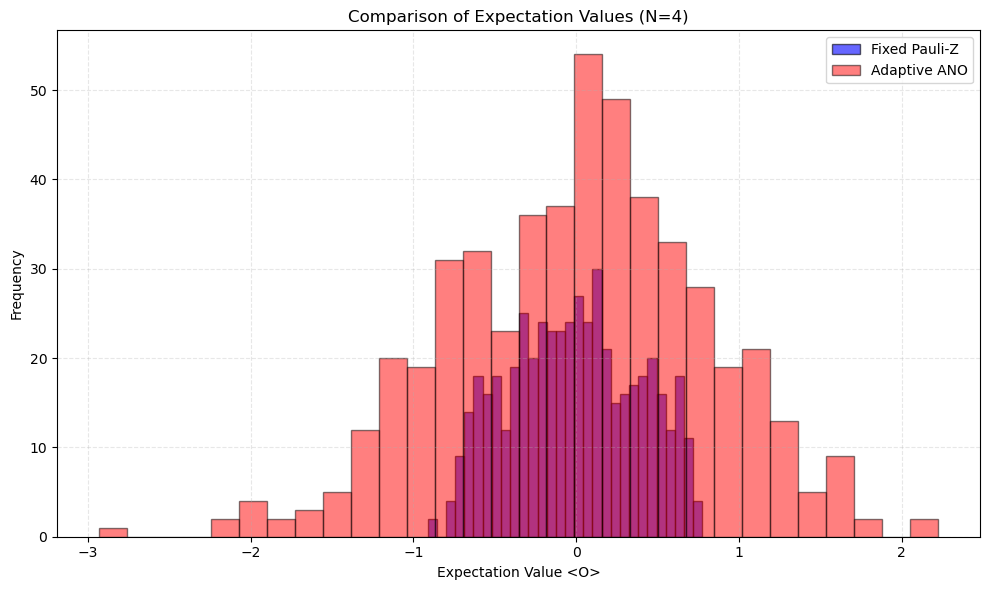

In [57]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def compare_ano_vs_pauli(n_qubits=2, n_layers=1, n_samples=300):
    """
    Compares the distribution of expectation values from fixed Pauli-Z vs. Adaptive ANO.
    """
    print(f"--- Comparing Measurement Capabilities (N={n_qubits}) ---")
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    # Calculate Ansatz Params (For StronglyEntanglingLayers: layers * qubits * 3)
    # Note: Updated to match the placeholder Ansatz logic
    ansatz_params_per_layer = 3 * (n_qubits - 1) + (n_qubits)
    total_ansatz_params = ansatz_params_per_layer * n_layers
    
    # Calculate ANO Params
    total_ano_params = count_ano_params(n_qubits)
    print(f"Ansatz Params: {total_ansatz_params}, ANO Params (per measurement): {total_ano_params}")

    # --- QNodes ---
    
    # 1. Fixed Pauli Measurement
    @qml.qnode(dev)
    def circuit_pauli(ansatz_params):
        CustomAnsatz(ansatz_params, wires=range(n_qubits), layers=n_layers)
        return qml.expval(qml.PauliZ(0)) 

    # 2. ANO Measurement
    @qml.qnode(dev)
    def circuit_ano(ansatz_params, ano_params):
        CustomAnsatz(ansatz_params, wires=range(n_qubits), layers=n_layers)
        H = build_ano_observable(ano_params, n_qubits)
        return qml.expval(qml.Hermitian(H, wires=range(n_qubits)))

    # --- Sampling ---
    pauli_vals = []
    ano_vals = []
    
    print(f"Sampling {n_samples} configurations...")
    for _ in tqdm(range(n_samples)):
        # Generate a random state (random ansatz parameters)
        a_params = np.random.uniform(0, 2*np.pi, total_ansatz_params)
        
        # 1. Get Pauli Value
        val_p = circuit_pauli(a_params)
        pauli_vals.append(val_p)
        
        # 2. Get ANO Value
        # Using uniform distribution for random Hermitian parameters
        h_params = np.random.uniform(-1, 1, total_ano_params)
        val_a = circuit_ano(a_params, h_params)
        ano_vals.append(val_a)

    # --- Plotting (Modified) ---
    plt.figure(figsize=(10, 6))
    
    # Plot Pauli Distribution
    plt.hist(pauli_vals, bins=30, color='blue', alpha=0.6, 
             label='Fixed Pauli-Z', edgecolor='black')
    
    # Plot ANO Distribution
    # alpha 값을 조절하여 두 히스토그램이 겹쳐 보여도 구분되도록 함
    plt.hist(ano_vals, bins=30, color='red', alpha=0.5, 
             label='Adaptive ANO', edgecolor='black')
    
    plt.title(f"Comparison of Expectation Values (N={n_qubits})")
    plt.xlabel("Expectation Value <O>")
    plt.ylabel("Frequency")
    
    # 범례 추가
    plt.legend(loc='upper right')
    
    # 그리드 추가 (가독성 향상)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    compare_ano_vs_pauli(n_qubits=4, n_layers=1, n_samples=500)

--- Circuit Visualization (N=4, L=1) ---


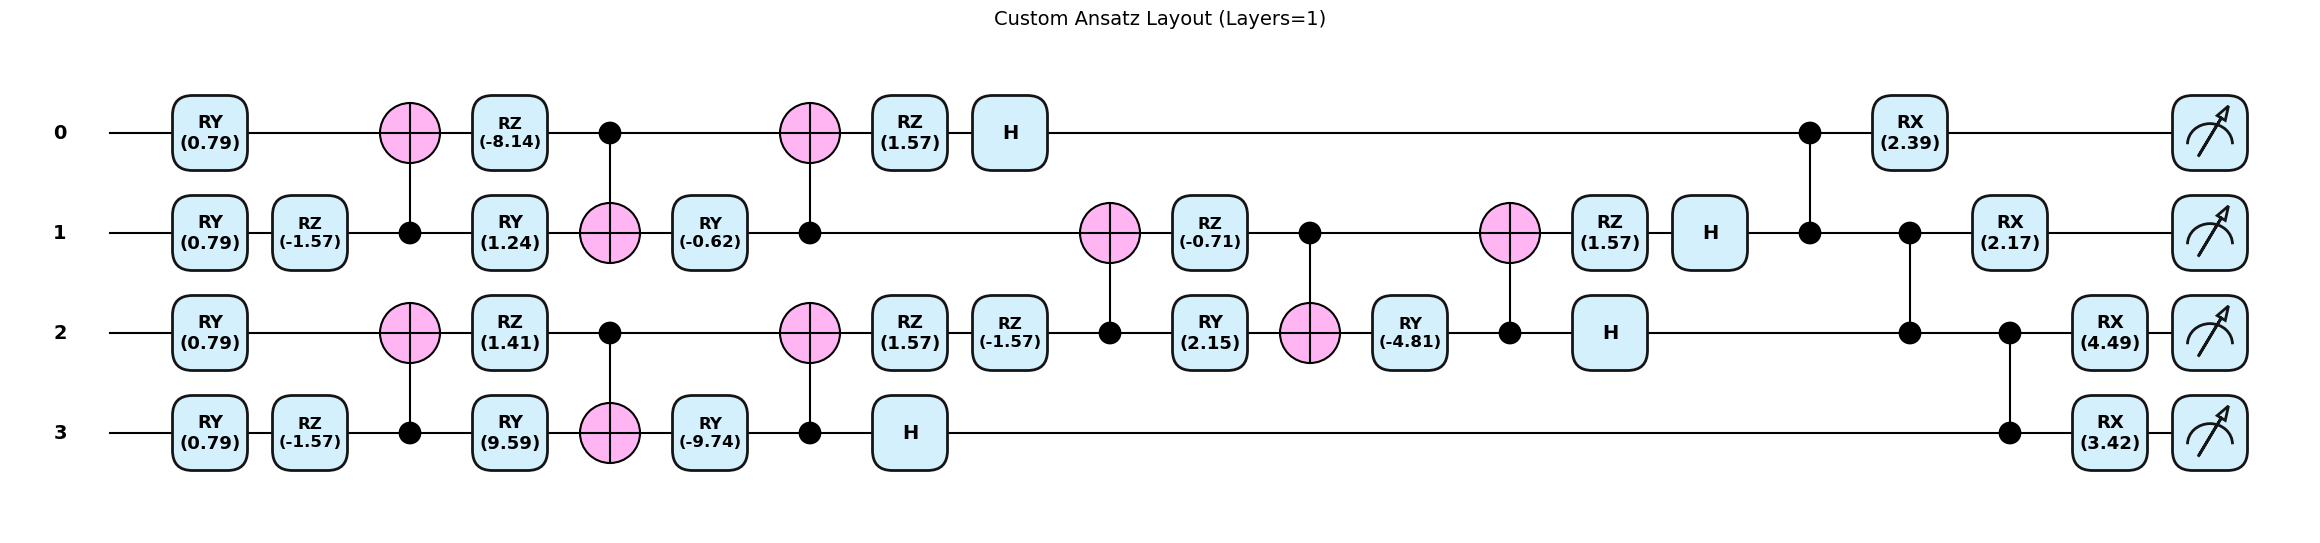

In [49]:
def draw_circuit_diagram(n_qubits=4, n_layers=2):
    """
    CustomAnsatz 회로 구조를 시각화하는 함수
    """
    print(f"--- Circuit Visualization (N={n_qubits}, L={n_layers}) ---")

    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def circuit_node(params):
        CustomAnsatz(params, wires=range(n_qubits), layers=n_layers)
        return qml.state()

    # ConvUnit: 3 * (N-1), PhaseMixing: N
    params_per_layer = 3 * (n_qubits - 1) + n_qubits
    total_params = params_per_layer * n_layers
    
    dummy_params = np.random.uniform(0, 2*np.pi, total_params)

    fig, ax = qml.draw_mpl(circuit_node, decimals=2, style='pennylane')(dummy_params)
    
    plt.title(f"Custom Ansatz Layout (Layers={n_layers})", fontsize=14)
    #plt.tight_layout()
    plt.show()

# ==========================================
# 실행 예시
# ==========================================
if __name__ == "__main__":
    draw_circuit_diagram(n_qubits=4, n_layers=1)